 <h1><center> <font color='green'>CNN Attention Module </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1> 

In [34]:
"""Importar librerias para realizar CNN"""
import os
"""Cargar las imagenes"""
import cv2
from PIL import Image
"""Tensoflow para las redes neuronales"""
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
"""Librería para calculo numerico"""
import numpy as np
"""Libreria para graficas"""
import matplotlib.pyplot as plt
"""Importa para dividir el conjunto de datos en entrenamiento y prueba"""
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
"""Importa datos de señales de registro de archivos de ejecuciones
de simulación disponibles para la aplicación en tiempo real seleccionadas"""
import time
import math
import logging

In [35]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [36]:
fpath = './vocales'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['e', 'i', 'a', 'o', 'u'] 

No. of categories =  5


In [37]:
"""Funcion para cargar las imagenes por categorias"""
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels
"""Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categories)
"""Mostrar la cantidad de imagenes cargadas"""
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1000 
No. of labels loaded =  1000
<class 'list'> <class 'list'>


In [38]:
"""Variables para ver el array de las imagenes y los label"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1000, 224, 224, 3) 
Labels shape =  (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


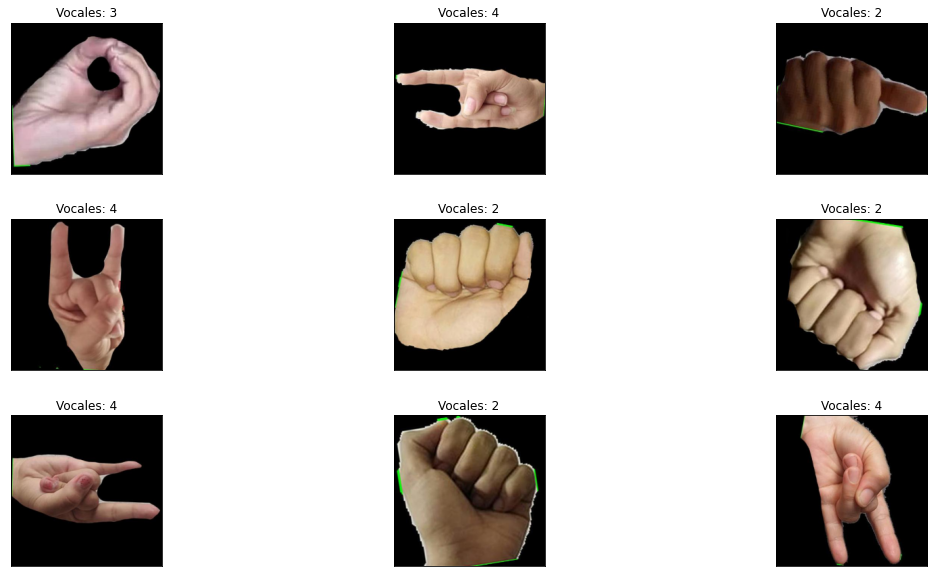

In [39]:
"""Función para visualizar imagenes aleatorias """
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])

        plt.title('Vocales: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
"""Mostrar imagenes con sus labels"""    
display_rand_images(images, labels)

<h1><center> <font color='brow'>Definición del conjunto de datos para pruebas y entrenamiento</font></center></h1> 

In [40]:
"""Primero se reorganizan los datos"""

"""Obtener números igualmente espaciados en un rango dado"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

"""Mezclar todos los valores igualmente espaciados en la lista 'n'"""
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

### Shuffling

In [41]:
"""El segundo paso es la mezcla de datos"""

"""imágenes aleatorias y datos de etiquetas correspondientes en ambas listas"""
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1000, 224, 224, 3) 
Labels shape after shuffling =  (1000,)


### Normalización

In [42]:
"""Normalizacion de los datos, segun su tipo: float, int"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1000, 224, 224, 3)


### Training and Testing

In [43]:
'''Se divide el conjunto de datos en 80% para entrenamiento y 20% para prueba'''
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]
"""Mostrar los array en cada parte del entrenamiento y la prueba"""
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (742, 224, 224, 3)
y_train shape =  (742,)

x_test shape =  (200, 224, 224, 3)
y_test shape =  (200,)

x_val shape =  (58, 224, 224, 3)
y_val shape =  (58,)


In [44]:
"""Estructura One-hot-encode"""
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)
y_val = to_categorical(y_val, 5)

 <h1><center> <font color='purple'>Configuración de Attention Module</font></center></h1> 

El siguiente método "ChannelAttention" nos permite producir un mapa de atención de canales explotando la relación de características entre canales. Dado que cada canal de un mapa de características se considera un detector de características, la atención del canal se centra en "qué" es significativo dada una imagen de entrada.

In [45]:
'''Método para configurar los canales del Attention'''
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool para aplicar la agrupación promedio en las dimensiones 
            # espaciales hasta que cada dimensión espacial es una y deja las demás dimensiones sin cambios. 
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool para analizar el contenido de una imagen por regiones 
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])


El siguiente método SpatialAttention nos permite genera un mapa de atención espacial utilizando la relación interespacial de características. A diferencia de la atención del canal, la atención espacial se centra en donde hay una parte informativa, que es complementaria a la atención del canal.

In [46]:

'''Método para la atención espacial en redes neuronales convolucionales.'''

class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
             # AvgPool para aplicar la agrupación promedio en las dimensiones 
            # espaciales hasta que cada dimensión espacial es una y deja las demás dimensiones sin cambios. 
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool para analizar el contenido de una imagen por regiones 
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

 <h1><center> <font color='blue'>Configuración de CNN con Attention Module</font></center></h1> 

In [47]:
'''Definimos la red neuronal CNN con attention module '''
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=x_train[0].shape, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax' )
])



In [48]:
'''Compilamos el modelo definido'''
simple_cnn_with_attention.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [49]:
'''Visualizamos el resumen de nuestro modelo'''
simple_cnn_with_attention.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 channel_attention_3 (Channe  (None, 224, 224, 32)     0         
 lAttention)                                                     
                                                      

In [51]:
x_train.shape,y_train.shape

((742, 224, 224, 3), (742, 5))

 <h1><center> <font color='green'>Entrenamiento del Modelo</font></center></h1> 

In [52]:
'''Definimos los Hiperparámetros del modelo CNN con attention module, para su entrenamiento'''
steps_per_epoch = (x_train.shape[0]//batch_size) 
validation_steps = (x_val.shape[0] // batch_size)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

start_time = time.time()
'''Entrenamos el modelo'''
history = simple_cnn_with_attention.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename=r"C:/Users/Joelv/Documents/ProyectoMineria/CNN_PURO_logs/CNN-Puaro_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
23/23 [==============================] - 6s 216ms/step - loss: 1.1392 - acc: 0.4864 - val_loss: 2.0180 - val_acc: 0.2500
Epoch 2/50
23/23 [==============================] - 4s 158ms/step - loss: 0.9857 - acc: 0.5704 - val_loss: 4.1501 - val_acc: 0.2500
Epoch 3/50
23/23 [==============================] - 4s 153ms/step - loss: 0.8913 - acc: 0.6408 - val_loss: 6.4149 - val_acc: 0.1250
Epoch 4/50
23/23 [==============================] - 4s 153ms/step - loss: 0.8309 - acc: 0.6338 - val_loss: 7.8085 - val_acc: 0.1562
Epoch 5/50
23/23 [==============================] - 4s 154ms/step - loss: 0.7370 - acc: 0.7127 - val_loss: 11.9195 - val_acc: 0.1875
Epoch 6/50
23/23 [==============================] - 4s 153ms/step - loss: 0.7031 - acc: 0.6930 - val_loss: 17.4179 - val_acc: 0.2500
Epoch 7/50
23/23 [==============================] - 4s 152ms/step - loss: 0.7464 - acc: 0.7042 - val_loss: 13.6010 - val_acc: 0.1250
Epoch 8/50
23/23 [==============================] - 3s 152ms/step - loss:

## Evaluación del modelo

In [53]:
"""Función de inicio del tiempo"""
start_time = time.time()

'''Métricas para la evaluación del modelo'''
loss, accuracy = simple_cnn_with_attention.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

7/7 [==============================] - 1s 100ms/step - loss: 0.5019 - acc: 0.8550
test_loss: 50.19
test_accuracy: 85.50


## Métricas de Evaluación


In [54]:
"""Función para las pruebas del modelo"""
model_probs = simple_cnn_with_attention.predict(x_test,batch_size=batch_size,verbose=0)
"""predecir clases nítidas para el conjunto de prueba"""
model_classes = np.argmax(model_probs,axis=1)
"""reducir a matriz 1d"""
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
"""Accuracy: (tp + tn) / (p + n)"""
accuracy = accuracy_score(y_test_reduced, model_classes)*100
"""Precision tp / (tp + fp)"""
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
"""Recall: tp / (tp + fn)"""
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
"""F1: 2 tp / (2 tp + fp + fn)"""
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

'''Imprimimos los resultados'''
print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)


Accuracy: 85.50
F1 score: 84.79
Precision: 88.65
Recall: 85.50


## Gráfica  History

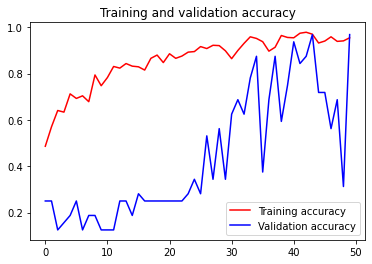

In [55]:

"""Funciones para graficar los history de validacion y el accuracy"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-Puro.png")
plt.show()

In [56]:
"""Predicción del Modelo"""
y_pred = simple_cnn_with_attention.predict(x_test)

In [57]:
"""Mostrar el array del y_pred"""
y_pred.round()

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0.

In [58]:
"""Visualización del Accuracy"""
accuracy_score(y_test, y_pred.round())*100

84.0

In [59]:
"""Visualizar las métricas del modelo"""

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78        56
           1       0.50      1.00      0.67        20
           2       0.98      0.88      0.93        50
           3       0.85      0.95      0.90        41
           4       0.93      0.93      0.93        30

   micro avg       0.84      0.85      0.85       197
   macro avg       0.84      0.89      0.84       197
weighted avg       0.89      0.85      0.85       197
 samples avg       0.84      0.84      0.84       197



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
"""Visualización del Accuracy"""
accuracy = simple_cnn_with_attention.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

7/7 [==============================] - 0s 43ms/step - loss: 0.5019 - acc: 0.8550
Accuracy:  85.50000190734863


 <h1><center> <font color='green'>Entrenamiento del Modelo</font></center></h1> 

In [61]:
'''Definimos las variables Y_pred_classes y Y_true para realizar la matriz de confusión '''
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

In [62]:
"""Reporte de clasificación de las métricas"""

report = classification_report(Y_true, Y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

           e       0.66      0.95      0.78        39
           i       1.00      0.50      0.67        40
           a       0.88      0.98      0.93        45
           o       0.95      0.87      0.91        46
           u       0.94      1.00      0.97        30

    accuracy                           0.85       200
   macro avg       0.89      0.86      0.85       200
weighted avg       0.89      0.85      0.85       200



 <h1><center> <font color='red'>Matriz de Confusión</font></center></h1> 

In [63]:
"""Estructurar la matriz de confusion"""

confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[37  0  2  0  0]
 [14 20  2  2  2]
 [ 1  0 44  0  0]
 [ 4  0  2 40  0]
 [ 0  0  0  0 30]]


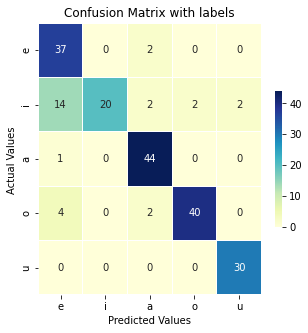

In [166]:
"""Librería para graficar la matriz de confusion"""
import seaborn as sns
'''Definimos la matríz de confusión'''
plt.figure(figsize=(5, 5))
ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True, cbar_kws={'shrink': .5}, linewidths=.1)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categories)
ma.yaxis.set_ticklabels(categories)

plt.show()